In [1]:
# Import packages.
import cvxpy as cp
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
'''
Experiment 0:
Normal distribution

Experiment 1:
beta in range(0, 1, 0.2) -> 0, 0.2, 0.4, 0.6, 0.8, 1; lambda = 0.5; box, elliposoid -> return
lambda in range(0, 1, 0.2) -> 0, 0.2, 0.4, 0.6, 0.8, 1; beta = 0.5; box, elliposoid -> return 
20240102,   1.47,  -0.34,  -1.15,   1.07,   0.40,  -2.21,   1.21,   1.29,  -0.70,   1.49,   0.41,  -0.75

Experiment 2:
in-sample vs out-of-sample
LSMT -> beta vs Transformer -> beta, box, elliposoid -> return
'''

'\nExperiment 0:\nNormal distribution\n\nExperiment 1:\nbeta in range(0, 1, 0.2) -> 0, 0.2, 0.4, 0.6, 0.8, 1; lambda = 0.5; box, elliposoid -> return\nlambda in range(0, 1, 0.2) -> 0, 0.2, 0.4, 0.6, 0.8, 1; beta = 0.5; box, elliposoid -> return \n20240102,   1.47,  -0.34,  -1.15,   1.07,   0.40,  -2.21,   1.21,   1.29,  -0.70,   1.49,   0.41,  -0.75\n\nExperiment 2:\nin-sample vs out-of-sample\nLSMT -> beta vs Transformer -> beta, box, elliposoid -> return\n'

In [3]:
# Set a random seed for reproducibility
np.random.seed(0)

# Define the mean and covariance matrix
mean = np.zeros(5)  # 5-dimensional mean vector (zero mean)
cov = np.eye(5)     # 5-dimensional identity matrix as covariance (unit variance)

# Generate 100 samples from the multivariate normal distribution
samples = np.random.multivariate_normal(mean, cov, size=100)

# Calculate the sample mean
sample_mean = np.mean(samples, axis=0)

# Calculate the sample covariance
sample_covariance = np.cov(samples, rowvar=False)  # rowvar=False indicates that columns represent variables

# Print the results
print("Sample Mean:", sample_mean)
print("Sample Covariance Matrix:\n", sample_covariance)

Sample Mean: [-0.10295661 -0.0168736  -0.05841267 -0.09427399  0.14574467]
Sample Covariance Matrix:
 [[ 1.02741042 -0.05090451 -0.10062808  0.06674109 -0.09579289]
 [-0.05090451  0.92438385 -0.10163889  0.05864348  0.13166902]
 [-0.10062808 -0.10163889  1.0121648   0.00909454  0.04728167]
 [ 0.06674109  0.05864348  0.00909454  1.08072143  0.1218436 ]
 [-0.09579289  0.13166902  0.04728167  0.1218436   0.94559535]]


In [4]:
# N assets
N = 5
# S sample size
S = 100
# Sigma
Sig = sample_covariance
# Sigma^{1/2}
Sig2 = np.linalg.cholesky(Sig)
print(np.allclose(Sig, Sig2 @ Sig2.T)) 
# muhat
mu = np.zeros((N,1))
#confidence level alpha
alpha = 0.05
# standard norm quantile
z_95 = stats.norm.ppf(1-alpha)
z_975 = stats.norm.ppf(1-alpha/2)
# delta^2 = chi^2 quantile
delta2 = stats.chi2.ppf(1-alpha, df=N)
# lambda0
lambda0 = 0.5
# beta
beta = 0.5


True


In [5]:
# Box uncertainty set
A = np.hstack((Sig2, np.zeros((N,1))))
c = mu + (1-2*beta)*(z_975/np.sqrt(S))*Sig2@np.ones((N,1))
c = np.append(c, 1)
c = c/((1-lambda0)*z_95)
e = np.ones(N+1)
e[-1] = 0

In [6]:
# set random seed
np.random.seed(0)
# objective function coeficient
f = np.zeros(N + 1)  
f[-1] = 1      

# define variables x=[w,t]^T
x = cp.Variable(N+1)
# SOC constraints
soc_constraints = [cp.SOC(c.T @ x , A @ x )]
# Define and solve the CVXPY problem.
prob = cp.Problem(cp.Minimize(f.T@x),
                  soc_constraints + [e.T @ x == 1])

prob.solve()
# Print result.
print("The optimal value:", prob.value)
print("Optimal solution x:", x.value)

The optimal value: 0.36953447925190247
Optimal solution x: [0.23252906 0.21130546 0.23541038 0.13255868 0.18819642 0.36953448]


In [7]:
w = x.value
w = x.value[:-1]
-w.T@mu + (1-lambda0)*z_95*np.linalg.norm(Sig2@w)

array([0.36953448])

[0.23252906 0.21130546 0.23541038 0.13255868 0.18819642 0.73906896]
[0.23252906 0.21130546 0.23541038 0.13255868 0.18819642 0.59125517]
[0.23252906 0.21130546 0.23541038 0.13255868 0.18819642 0.44344137]
[0.23252906 0.21130546 0.23541038 0.13255868 0.18819642 0.29562758]
[0.23252906 0.21130546 0.23541038 0.13255868 0.18819642 0.14781379]


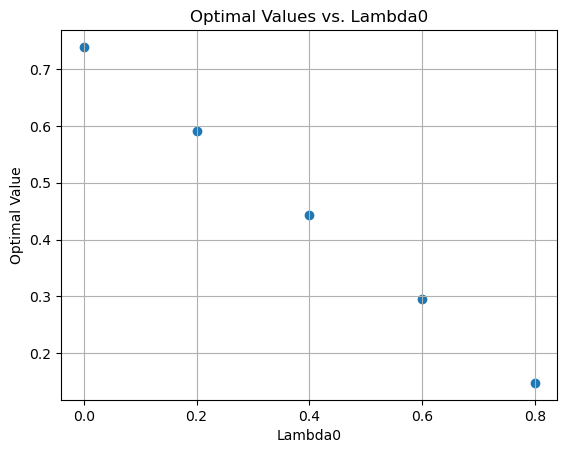

In [9]:
# Initialize results storage
lambda_values = np.arange(0, 1, 0.2)  # lambda0 from 0 to 1 with step 0.2
results = []
resultsw = np.zeros((len(lambda_values), N + 1))
for i, lambda0 in enumerate(lambda_values):
    # Box uncertainty set
    c = mu + (1 - 2 * beta) * (z_975 / np.sqrt(S)) * Sig2 @ np.ones((N, 1))
    c = np.append(c, 1)
    c = c / ((1 - lambda0) * z_95)
    e = np.ones(N + 1)
    e[-1] = 0

    # Set random seed
    np.random.seed(0)

    # Objective function coefficient
    f = np.zeros(N + 1)
    f[-1] = 1

    # Define variables x = [w, t]^T
    x = cp.Variable(N + 1)

    # SOC constraints
    soc_constraints = [cp.SOC(c.T @ x, A @ x)]

    # Define and solve the CVXPY problem
    prob = cp.Problem(cp.Minimize(f.T @ x), soc_constraints + [e.T @ x == 1])
    prob.solve()

    # Store the results
    results.append(prob.value)
    resultsw[i] = x.value
    print(resultsw[i])
# Convert results to a NumPy array for easier plotting
results = np.array(results)

# Plotting the results
plt.scatter(lambda_values, results, marker='o')
plt.title('Optimal Values vs. Lambda0')
plt.xlabel('Lambda0')
plt.ylabel('Optimal Value')
plt.xticks(lambda_values)
plt.grid()
plt.savefig('box_lambda.pdf', dpi=800)
plt.show()

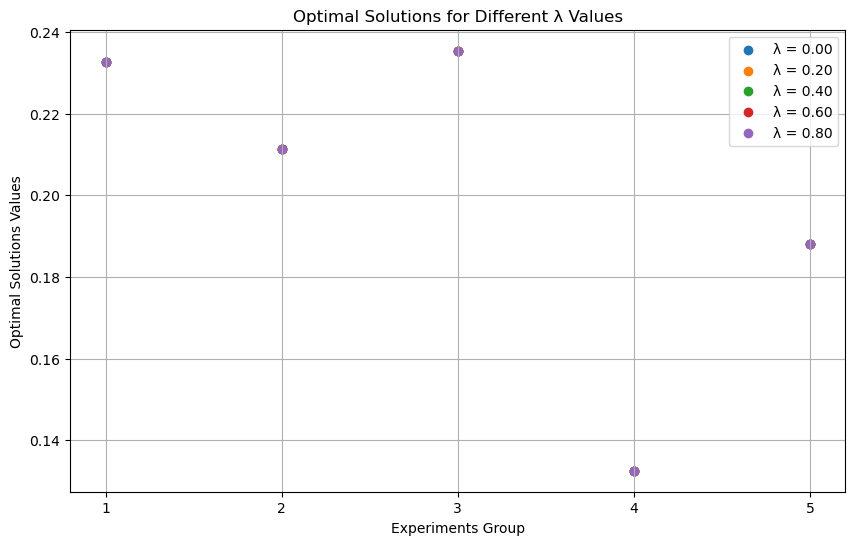

In [28]:
plt.figure(figsize=(10, 6))
for i in range(len(lambda_values)):
    plt.scatter([1,2,3,4,5],resultsw[i][:-1], label=f'λ = {lambda_values[i]:.2f}')
#[1, 2, 3] [1, 2, 3]
plt.title('Optimal Solutions for Different λ Values')
plt.ylabel('Optimal Solutions Values')
plt.xlabel('Experiments Group')
plt.xticks([1, 2, 3, 4, 5])
plt.legend()
plt.grid()
plt.savefig('box_lambda_w.pdf', dpi=800)
plt.show()

In [15]:
A1 = np.hstack((Sig2, np.zeros((N,1))))
c1 = np.append(mu, 1)
a = (1-lambda0)*z_95 + (1-2*beta)*np.sqrt(delta2/S)
c1 = c1/a
e1 = np.ones(N+1)
e1[-1] = 0
print(e1)

[1. 1. 1. 1. 1. 0.]


In [16]:
# set random seed
np.random.seed(0)
# objective function coeficient
f1 = np.zeros(N + 1) 
f1[-1] = 1      
print(f1.shape)

# define variables x=[w,t]^T
x1 = cp.Variable(N+1)
# SOC constraints
soc_constraints1 = [cp.SOC(c1.T @ x1 , A1 @ x1 )]
# Define and solve the CVXPY problem.
prob1 = cp.Problem(cp.Minimize(f1.T@x1),
                  soc_constraints1 + [e1.T @ x1 == 1])

prob1.solve()
# Print result.
print("The optimal value:", prob1.value)
print("Optimal solution x:", x1.value)

(6,)
The optimal value: 0.14781379331993474
Optimal solution x: [0.23252906 0.21130546 0.23541038 0.13255868 0.18819642 0.14781379]
